# Strategies to deal with unknown class

## Common Parameters

In [4]:
sys.path.append("..") # Adds higher directory to python modules path.
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
from helpers import *
from visuals import *
from data.data_loader import *
from collections import Counter

import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from visuals import plot_confusion_matrix
from tensorflow.keras import utils
from keras_numpy_backend import categorical_crossentropy

%load_ext autoreload
%autoreload 2
%matplotlib inline

data_folder = "../data/isic2019/sampled_balanced_82400_224"
model_folder = 'models'
history_folder = 'history'
pred_result_folder_test = 'test_predict_results'

model_name = 'DenseNet201'
postfix = 'best_balanced_acc'

models_info = read_models_info(history_folder, pred_result_folder_test)

model = filter_models_info(
    models_info, 
    models=["DenseNet201"],
    parameters={
        "balanced": 1,
        "feepochs": 2, 
        "ftepochs": 100, 
        "felr": 0.001,
        "ftlr": 0.0001,
        "batch": 16,
        "lambda": None,
        "dropout": None,
        "dggroup": "11",
        "samples": 82400
    },
)[0]

unknown_paths = [o for o in os.listdir(model["pred_test_0"]) if os.path.isdir(os.path.join(model["pred_test_0"],o))]
print(unknown_paths)
pred_folders = []

for i, path in enumerate(unknown_paths): 
    file_path = os.path.join(model["pred_test_0"], path, "best_balanced_acc.csv")
    pred_folders.append({"file_path": file_path, "unknown":path.replace("_", " ")})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['no_unknown', 'unknown_0.2', 'unknown_0.3', 'unknown_0.4', 'unknown_0.5', 'unknown_0.25', 'unknown_0.35', 'unknown_0.45', 'odin_LOGISTIC', 'unknown_0.6', 'unknown_0.7', 'unknown_0.8', 'unknown_0.9']


# Compute test metrics with unknown class
# DenseNet201:
* Feature extract epochs: 6.
* Start learning rate: 0.001000
* Fine tuning learning rate: 0.000010
* Dropout rate: 0.300000
* Lambda(l2): None
* Batch size: 16

## Test data distribution

Test data has 5195 samples.
'MEL':	904	(17.40%)
'NV':	2575	(49.57%)
'BCC':	665	(12.80%)
'AK':	173	(3.33%)
'BKL':	525	(10.11%)
'DF':	48	(0.92%)
'VASC':	51	(0.98%)
'SCC':	126	(2.43%)
'UNK':	128	(2.46%)


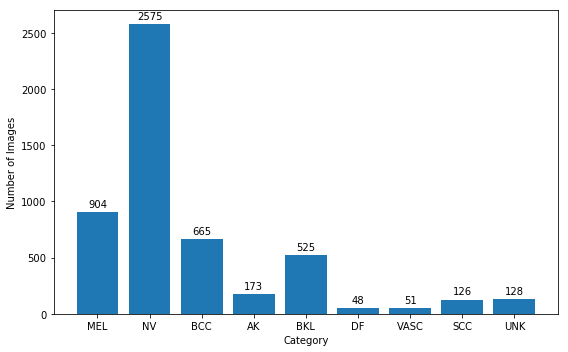

In [5]:
training_image_folder = os.path.join(data_folder, 'ISIC_2019_Test_Input')
ground_truth_file = os.path.join(data_folder, 'ISIC_2019_Test_GroundTruth_Unknown.csv')

df_test_ground_truth, known_category_names, unknown_category_name = load_isic_training_data(
    training_image_folder, 
    ground_truth_file,
    test=True
)
known_category_num = len(known_category_names)
unknown_category_num = 1
all_category_names = known_category_names + [unknown_category_name]
all_category_num = known_category_num + unknown_category_num

count_per_category = Counter(df_test_ground_truth['category'])
total_sample_count = sum(count_per_category.values())
print("Test data has {} samples.".format(total_sample_count))
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category[i], count_per_category[i]*100/total_sample_count))

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')
ax.set(xlabel='Category', ylabel='Number of Images')
rects = plt.bar(all_category_names, [count_per_category[i] for i in range(all_category_num)])
autolabel(ax, rects)
fig.tight_layout()

## Confusion matrixes comparisson

>>>>>>>>>>>>>>>>>>> no unknown <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.8456207892204043
balanced_accuracy_score:  0.7247495399871648


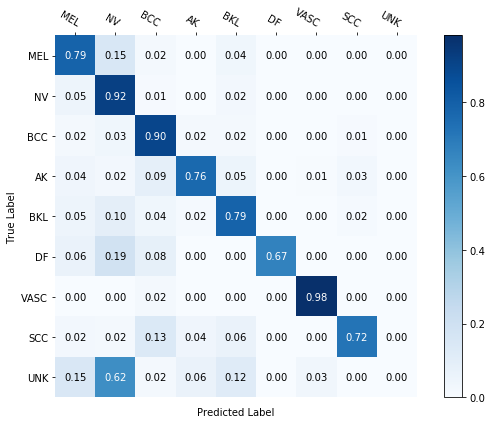

>>>>>>>>>>>>>>>>>>> unknown 0.2 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.8456207892204043
balanced_accuracy_score:  0.7247495399871648


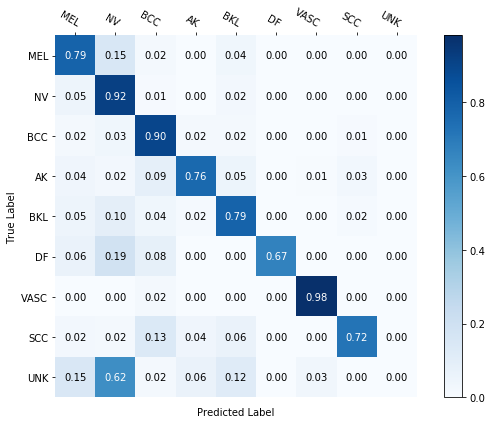

>>>>>>>>>>>>>>>>>>> unknown 0.3 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.8456207892204043
balanced_accuracy_score:  0.7247495399871648


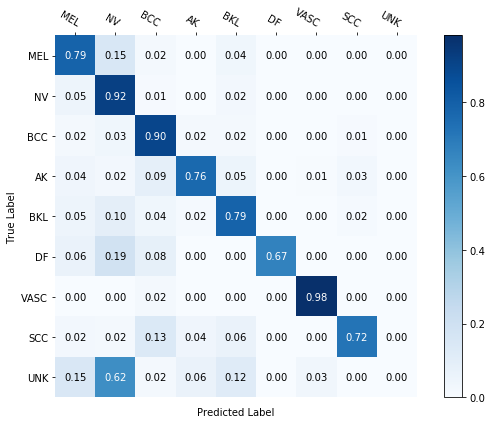

>>>>>>>>>>>>>>>>>>> unknown 0.4 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.8448508180943215
balanced_accuracy_score:  0.7222681411017363


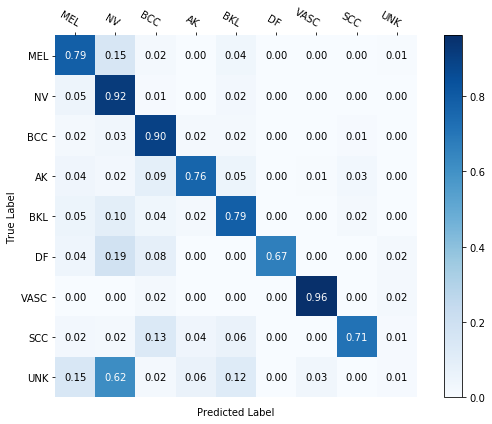

>>>>>>>>>>>>>>>>>>> unknown 0.5 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.8433108758421559
balanced_accuracy_score:  0.7213992645102598


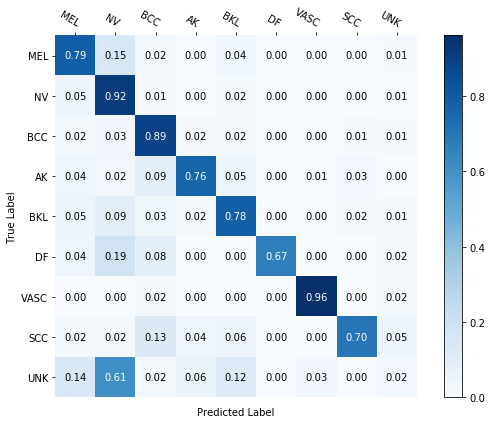

>>>>>>>>>>>>>>>>>>> unknown 0.25 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.8456207892204043
balanced_accuracy_score:  0.7247495399871648


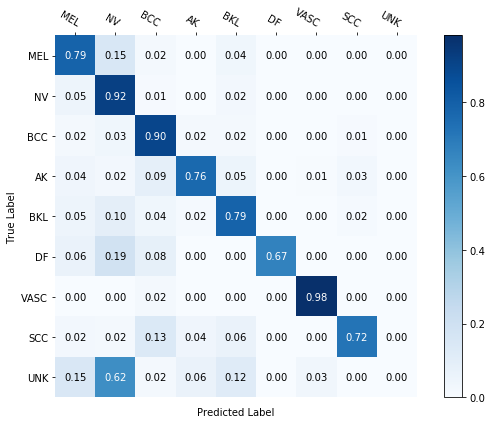

>>>>>>>>>>>>>>>>>>> unknown 0.35 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.8454282964388835
balanced_accuracy_score:  0.722570890749692


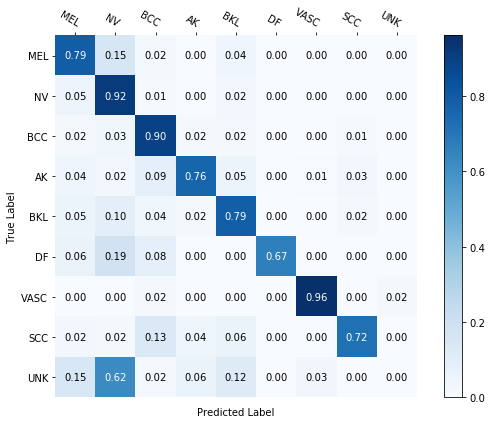

>>>>>>>>>>>>>>>>>>> unknown 0.45 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.8442733397497594
balanced_accuracy_score:  0.7219212175973104


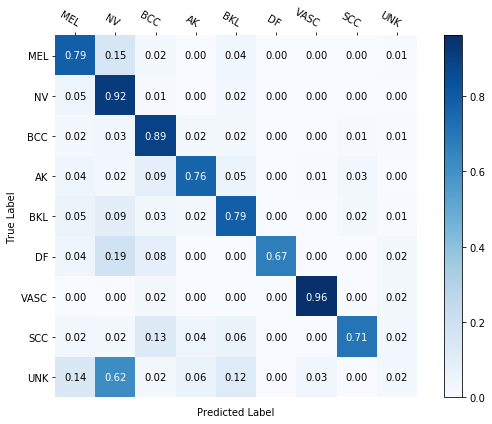

>>>>>>>>>>>>>>>>>>> odin LOGISTIC <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.8105871029836381
balanced_accuracy_score:  0.7063767709639593


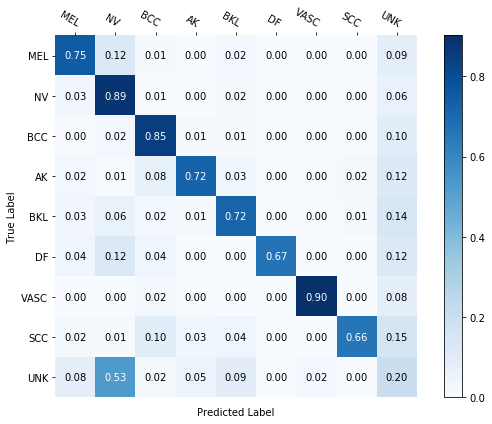

>>>>>>>>>>>>>>>>>>> unknown 0.6 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.8346487006737248
balanced_accuracy_score:  0.7225302564996257


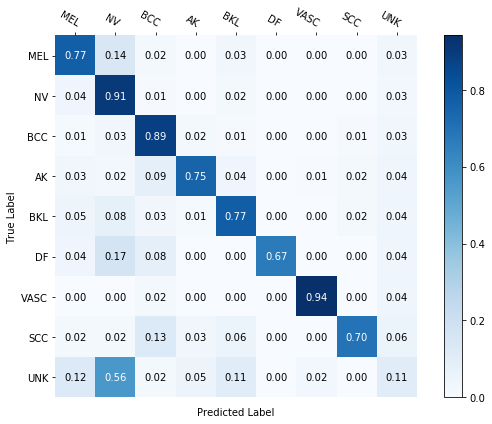

>>>>>>>>>>>>>>>>>>> unknown 0.7 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.8225216554379211
balanced_accuracy_score:  0.7205644312038759


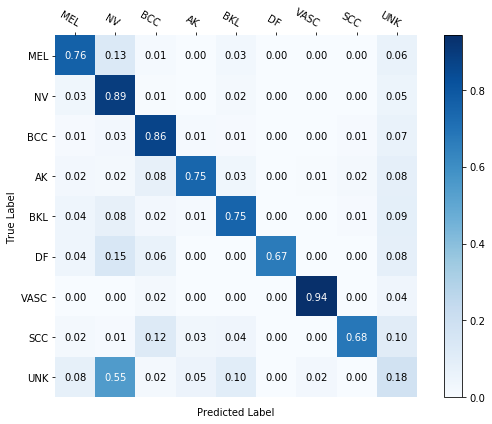

>>>>>>>>>>>>>>>>>>> unknown 0.8 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.8059672762271415
balanced_accuracy_score:  0.7059729933448866


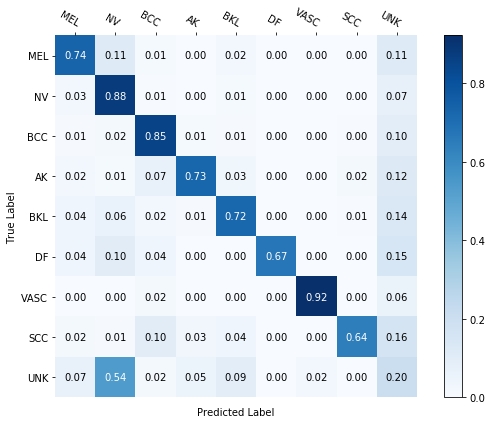

>>>>>>>>>>>>>>>>>>> unknown 0.9 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.7794032723772859
balanced_accuracy_score:  0.6863584488531799


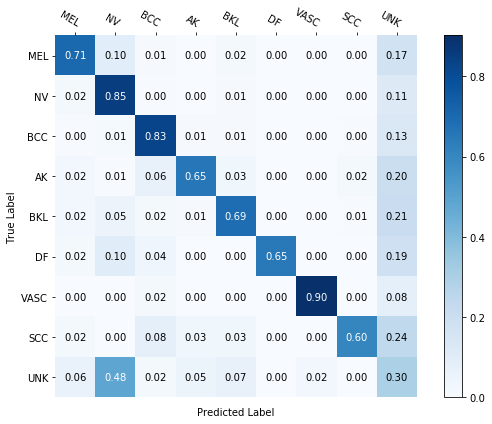

In [40]:
thresh_labels = []
thresh_bma = []
thresh_acc = []

for pred_unknown_threshold in pred_folders:
    df_pred = pd.read_csv(pred_unknown_threshold["file_path"])
    df = pd.merge(df_pred, df_test_ground_truth, on='image')
    y_true = df['category']
    y_pred = df['pred_category']
    df.to_csv("test.csv")

    print(f">>>>>>>>>>>>>>>>>>> {pred_unknown_threshold['unknown']} <<<<<<<<<<<<<<<<<<<<<")
    acc = accuracy_score(y_true, y_pred)
    bma = balanced_accuracy_score(y_true, y_pred)
    # Compute Balanced Accuracy
    print('accuracy: ', acc)
    print('balanced_accuracy_score: ', bma)
    # Confusion Matrix
    fig = plot_confusion_matrix(
        y_true, 
        y_pred, 
        all_category_names, 
        normalize=True,
        figsize=(8, 6)
    )
    plt.show()
    
    if pred_unknown_threshold['unknown']=="odin LOGISTIC":
        fig.savefig(os.path.join("densenet121_conf_matrix_odin.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
    else:
        label = 0.0 if pred_unknown_threshold['unknown']=="no unknown" else float(pred_unknown_threshold['unknown'].split()[1])
        thresh_labels.append(label)
        thresh_bma.append(bma)
        thresh_acc.append(acc)

## Threshold comparisson

(0.0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8)
(0.8456207892204043, 0.8456207892204043, 0.8448508180943215, 0.8433108758421559, 0.8346487006737248, 0.8225216554379211, 0.8059672762271415)
(0.7247495399871648, 0.7247495399871648, 0.7222681411017363, 0.7213992645102598, 0.7225302564996257, 0.7205644312038759, 0.7059729933448866)


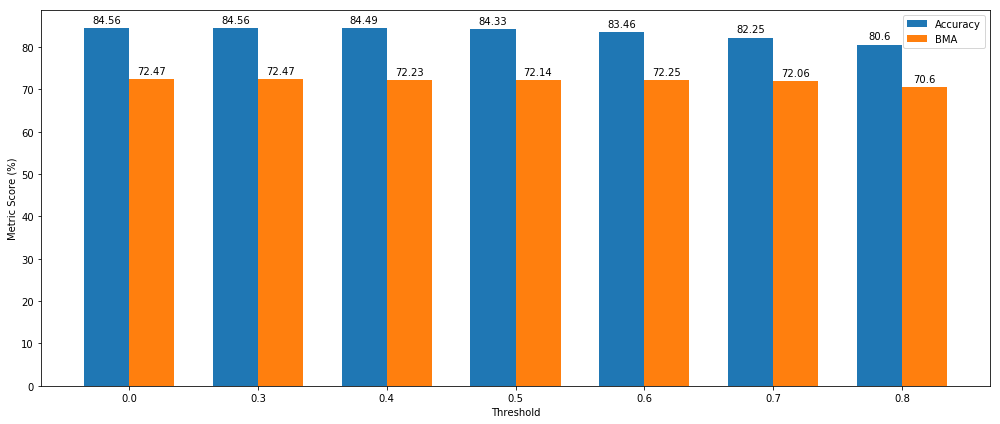

In [58]:
THRESHOLDS_FILTER = [0.0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
filtered_thresh_labels = []
filtered_thresh_acc = []
filtered_thresh_bma = []

for i in range(len(thresh_labels)):
    if thresh_labels[i] in THRESHOLDS_FILTER:
        filtered_thresh_labels.append(thresh_labels[i])
        filtered_thresh_acc.append(thresh_acc[i])
        filtered_thresh_bma.append(thresh_bma[i])

filtered_thresh_labels, filtered_thresh_acc, filtered_thresh_bma = zip(*sorted(zip(
    filtered_thresh_labels, 
    filtered_thresh_acc, 
    filtered_thresh_bma
)))
print(filtered_thresh_labels)
print(filtered_thresh_acc)
print(filtered_thresh_bma)

fig = plot_grouped_2bars(
    scalars=[[round(filtered_thresh_acc[i]*100, 2) for i in range(len(filtered_thresh_labels))],
             [round(filtered_thresh_bma[i]*100, 2) for i in range(len(filtered_thresh_labels))]],
    scalarlabels=['Accuracy', 'BMA'],
    xticklabels=filtered_thresh_labels,
    xlabel='Threshold',
    ylabel='Metric Score (%)',
    figsize=(14,6)
)

fig.savefig(os.path.join("densenet121_threshold_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
